In [1]:
import os

os.environ["KERAS_BACKEND"] = "jax"

import numpy as np
import matplotlib.pyplot as plt
import unicodedata
import string
import pandas as pd
import torch

import keras
from keras import models
from keras import layers
from keras import losses
from keras import metrics
import torchvision
from torch.utils.data import Dataset, DataLoader

from utils import CustomEvalDataset

plt.style.use("seaborn-v0_8-notebook")
plt.style.use("petroff10")
plt.set_loglevel("info")

print(f"Keras: {keras.__version__}")
print(f"Numpy: {np.__version__}")

Keras: 3.9.0
Numpy: 2.2.3


In [2]:
to_numpy_array = lambda img: np.array(img, dtype=np.float32) / 255.0

mnist_data_train = torchvision.datasets.MNIST(
    "./data",
    train=True,
    download=True,
    transform=to_numpy_array,
)
mnist_data_test = torchvision.datasets.MNIST(
    "./data",
    train=False,
    download=True,
    transform=to_numpy_array,
)
x_example, y_example = mnist_data_train[0]

In [3]:
B = 32
mnist_train_loader = DataLoader(mnist_data_train, batch_size=B, shuffle=True)
mnist_test_loader = DataLoader(mnist_data_test, batch_size=B)

In [4]:
# How many values are in the input? We use this to help determine the size of subsequent layers
D = 28 * 28  # 28 * 28 images
# Hidden layer size
n = 256
# How many channels are in the input?
C = 1
# How many classes are there?
classes = 10
x_shape = (28, 28)

# Create our regular model
model_regular = models.Sequential(
    [
        layers.Input(shape=x_shape),
        layers.Flatten(),
        layers.Dense(n, activation="tanh"),
        layers.Dense(n, activation="tanh"),
        layers.Dense(n, activation="tanh"),
        layers.Dense(classes, activation="softmax"),
    ]
)

model_regular.compile(
    optimizer="SGD",
    loss=losses.SparseCategoricalCrossentropy(),
    metrics=[metrics.SparseCategoricalAccuracy()],
)

fc_callback_predict_test = CustomEvalDataset(datasets=mnist_test_loader)
fc_results = model_regular.fit(
    mnist_train_loader, callbacks=[fc_callback_predict_test], epochs=10, verbose=2
)

Epoch 1/10
1875/1875 - 4s - 2ms/step - loss: 0.4906 - sparse_categorical_accuracy: 0.8691
Epoch 2/10
1875/1875 - 3s - 2ms/step - loss: 0.2893 - sparse_categorical_accuracy: 0.9164
Epoch 3/10
1875/1875 - 3s - 1ms/step - loss: 0.2493 - sparse_categorical_accuracy: 0.9279
Epoch 4/10
1875/1875 - 3s - 1ms/step - loss: 0.2188 - sparse_categorical_accuracy: 0.9372
Epoch 5/10
1875/1875 - 3s - 2ms/step - loss: 0.1929 - sparse_categorical_accuracy: 0.9443
Epoch 6/10
1875/1875 - 3s - 1ms/step - loss: 0.1711 - sparse_categorical_accuracy: 0.9513
Epoch 7/10
1875/1875 - 3s - 1ms/step - loss: 0.1534 - sparse_categorical_accuracy: 0.9556
Epoch 8/10
1875/1875 - 3s - 1ms/step - loss: 0.1390 - sparse_categorical_accuracy: 0.9597
Epoch 9/10
1875/1875 - 3s - 1ms/step - loss: 0.1264 - sparse_categorical_accuracy: 0.9633
Epoch 10/10
1875/1875 - 3s - 2ms/step - loss: 0.1160 - sparse_categorical_accuracy: 0.9667


In [5]:
# Create our regular model
h2_layer = layers.Dense(n, activation="tanh")
model_shared = models.Sequential(
    [
        layers.Input(shape=x_shape),
        layers.Flatten(),
        layers.Dense(n, activation="tanh"),
        h2_layer,
        h2_layer,
        layers.Dense(classes, activation="softmax"),
    ]
)

model_shared.compile(
    optimizer="SGD",
    loss=losses.SparseCategoricalCrossentropy(),
    metrics=[metrics.SparseCategoricalAccuracy()],
)

fc_shared_callback_predict_test = CustomEvalDataset(datasets=mnist_test_loader)
fc_shared_result = model_shared.fit(
    mnist_train_loader,
    callbacks=[fc_shared_callback_predict_test],
    epochs=10,
    verbose=2,
)

Epoch 1/10
1875/1875 - 4s - 2ms/step - loss: 0.4846 - sparse_categorical_accuracy: 0.8702
Epoch 2/10
1875/1875 - 3s - 2ms/step - loss: 0.2880 - sparse_categorical_accuracy: 0.9162
Epoch 3/10
1875/1875 - 3s - 1ms/step - loss: 0.2484 - sparse_categorical_accuracy: 0.9283
Epoch 4/10
1875/1875 - 3s - 1ms/step - loss: 0.2175 - sparse_categorical_accuracy: 0.9375
Epoch 5/10
1875/1875 - 3s - 1ms/step - loss: 0.1909 - sparse_categorical_accuracy: 0.9456
Epoch 6/10
1875/1875 - 3s - 2ms/step - loss: 0.1697 - sparse_categorical_accuracy: 0.9516
Epoch 7/10
1875/1875 - 3s - 1ms/step - loss: 0.1515 - sparse_categorical_accuracy: 0.9566
Epoch 8/10
1875/1875 - 3s - 1ms/step - loss: 0.1373 - sparse_categorical_accuracy: 0.9600
Epoch 9/10
1875/1875 - 3s - 1ms/step - loss: 0.1247 - sparse_categorical_accuracy: 0.9640
Epoch 10/10
1875/1875 - 3s - 1ms/step - loss: 0.1144 - sparse_categorical_accuracy: 0.9670


<Axes: xlabel='epochs', ylabel='Accuracy'>

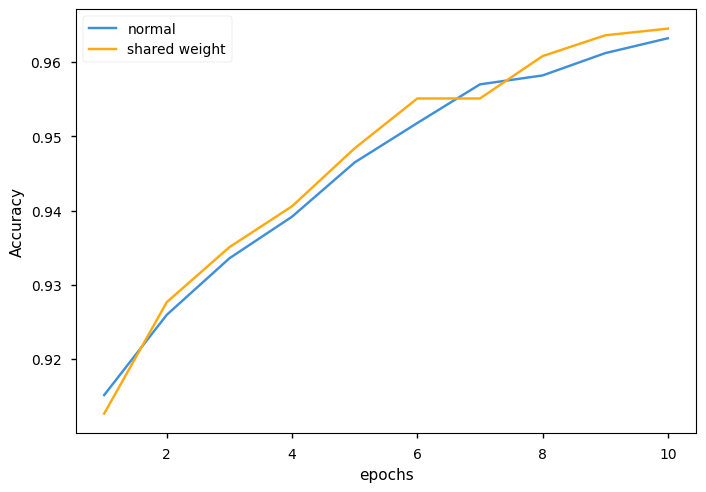

In [6]:
pd.DataFrame(
    {
        "epochs": np.arange(1, 11, 1),
        "normal": fc_callback_predict_test.list_metrics,
        "shared weight": fc_shared_callback_predict_test.list_metrics,
    }
).set_index("epochs").plot(ylabel="Accuracy")

In [7]:
zip_file_url = "https://download.pytorch.org/tutorial/data.zip"

import requests, zipfile, io

r = requests.get(zip_file_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

# Zip file is organized as data/names/[LANG].txt , where [LANG] is a specific language

In [8]:
namge_language_data = {}

# We will use some code to remove UNICODE tokens to make life easy for us processing wise
# e.g., convert something like "Ślusàrski" to Slusarski
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
alphabet = {}
for i in range(n_letters):
    alphabet[all_letters[i]] = i


# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return "".join(
        c
        for c in unicodedata.normalize("NFD", s)
        if unicodedata.category(c) != "Mn" and c in all_letters
    )


# Loop through every language, open the zip file entry, and read all the lines from the text file.
for zip_path in z.namelist():
    if "data/names/" in zip_path and zip_path.endswith(".txt"):
        lang = zip_path[len("data/names/"): -len(".txt")]
        with z.open(zip_path) as myfile:
            lang_names = [
                unicodeToAscii(line).lower()
                for line in str(myfile.read(), encoding="utf-8").strip().split("\n")
            ]
            namge_language_data[lang] = lang_names
        print(lang, ": ", len(lang_names))  # Print out the name of each language too.

Arabic :  2000
Chinese :  268
Czech :  519
Dutch :  297
English :  3668
French :  277
German :  724
Greek :  203
Irish :  232
Italian :  709
Japanese :  991
Korean :  94
Polish :  139
Portuguese :  74
Russian :  9408
Scottish :  100
Spanish :  298
Vietnamese :  73


In [9]:
class LanguageNameDataset(Dataset):
    def __init__(self, lang_name_dict, vocabulary):
        self.label_names = [x for x in lang_name_dict.keys()]
        self.data = []
        self.labels = []
        self.vocabulary = vocabulary
        for y, language in enumerate(self.label_names):
            for sample in lang_name_dict[language]:
                self.data.append(sample)
                self.labels.append(y)

    def __len__(self):
        return len(self.data)

    def string2InputVec(self, input_string):
        """
        This method will convert any input string into a vector of long values, according to the vocabulary used by this object.
        input_string: the string to convert to a tensor
        """
        T = len(input_string)  # How many characters long is the string?

        # Create a new tensor to store the result in
        name_vec = np.zeros((T), dtype=np.int64)
        # iterate through the string and place the appropriate values into the tensor
        for pos, character in enumerate(input_string):
            name_vec[pos] = self.vocabulary[character]

        return name_vec

    def __getitem__(self, idx):
        name = self.data[idx]
        label = self.labels[idx]

        # Conver the correct class label into a tensor for PyTorch
        label_vec = np.array([label], dtype=np.int64)

        return self.string2InputVec(name), label

In [10]:
dataset = LanguageNameDataset(namge_language_data, alphabet)

train_data, test_data = torch.utils.data.random_split(
    dataset, (len(dataset) - 300, 300)
)

train_loader = DataLoader(train_data, batch_size=1, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

In [11]:
for e in train_loader:
    print(e)
    break

[tensor([[ 7, 11, 14,  1, 24, 18, 19,  8, 13]]), tensor([14])]


In [12]:
dataset[300]

(array([18,  0, 12,  0,  7,  0]), 0)

In [13]:
input_sequence = np.array([0, 1, 1, 0, 2], dtype=np.int64)
embeding_layer = layers.Embedding(3, 2)
x_seq = embeding_layer(input_sequence)
print(input_sequence.shape, x_seq.shape)

(5,) (5, 2)


In [14]:
D = 64
vocab_size = len(all_letters)
hidden_nodes = 256
classes = len(dataset.label_names)

In [15]:
input_sequence.shape

(5,)

In [16]:
first_rnn = models.Sequential(
    [
        layers.Input(shape=(12,)),
        layers.Embedding(vocab_size, D),
        layers.SimpleRNN(hidden_nodes),
        layers.Dense(classes, activation="softmax"),  # (B, D) -> (B, classes)
    ]
)

first_rnn.compile(
    optimizer="SGD",
    loss=losses.SparseCategoricalCrossentropy(),
    metrics=[metrics.SparseCategoricalAccuracy()],
)

In [17]:
[dataset[0][0].shape, dataset[1][0].shape]

[(6,), (5,)]

In [18]:
layers.Embedding(vocab_size, D)(dataset[0][0]).shape

(6, 64)

In [19]:
first_rnn_callback_predict_test = CustomEvalDataset(datasets=test_loader)
first_rnn_result = first_rnn.fit(
    train_loader,
    callbacks=[first_rnn_callback_predict_test],
    epochs=20,
    batch_size=16,
    verbose=2,
)

Epoch 1/20
19774/19774 - 17s - 860us/step - loss: 1.1716 - sparse_categorical_accuracy: 0.6517
Epoch 2/20
19774/19774 - 13s - 660us/step - loss: 0.9853 - sparse_categorical_accuracy: 0.7021
Epoch 3/20
19774/19774 - 13s - 665us/step - loss: 0.8888 - sparse_categorical_accuracy: 0.7342
Epoch 4/20
19774/19774 - 13s - 638us/step - loss: 0.8324 - sparse_categorical_accuracy: 0.7534
Epoch 5/20
19774/19774 - 12s - 625us/step - loss: 0.7842 - sparse_categorical_accuracy: 0.7653
Epoch 6/20
19774/19774 - 13s - 640us/step - loss: 0.7596 - sparse_categorical_accuracy: 0.7765
Epoch 7/20
19774/19774 - 13s - 634us/step - loss: 0.7342 - sparse_categorical_accuracy: 0.7826
Epoch 8/20
19774/19774 - 13s - 634us/step - loss: 0.7392 - sparse_categorical_accuracy: 0.7849
Epoch 9/20
19774/19774 - 13s - 654us/step - loss: 0.7396 - sparse_categorical_accuracy: 0.7864
Epoch 10/20
19774/19774 - 13s - 636us/step - loss: 0.7361 - sparse_categorical_accuracy: 0.7890
Epoch 11/20
19774/19774 - 12s - 622us/step - loss

In [20]:
first_rnn.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 12, 64)         │         3,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 256)            │        82,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 18)             │         4,626 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 90,452 (353.33 KB)

 Trainable params: 90,450 (353.32 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (8.00 B)

<Axes: >

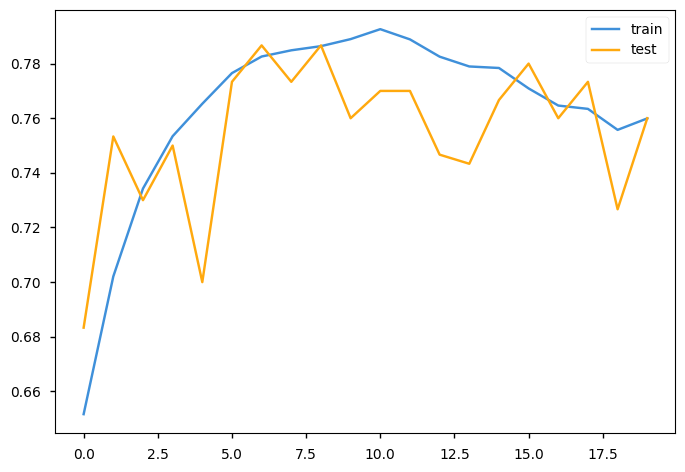

In [21]:
pd.DataFrame(
    {
        "train": first_rnn_result.history["sparse_categorical_accuracy"],
        "test": first_rnn_callback_predict_test.list_metrics,
    }
).plot()

In [22]:
rnn_3layer = models.Sequential(
    [
        layers.Input(shape=(12,)),
        layers.Embedding(vocab_size, D),
        layers.SimpleRNN(hidden_nodes, return_sequences=True),
        layers.SimpleRNN(hidden_nodes, return_sequences=True),
        layers.SimpleRNN(hidden_nodes),
        layers.Dense(classes, activation="softmax"),  # (B, D) -> (B, classes)
    ]
)

rnn_3layer.compile(
    optimizer="SGD",
    loss=losses.SparseCategoricalCrossentropy(),
    metrics=[metrics.SparseCategoricalAccuracy()],
)

In [23]:
rnn_3layer_callback_predict_test = CustomEvalDataset(datasets=test_loader)
rnn_3layer_result = rnn_3layer.fit(
    train_loader,
    callbacks=[rnn_3layer_callback_predict_test],
    epochs=20,
    batch_size=16,
    verbose=2,
)

Epoch 1/20
19774/19774 - 39s - 2ms/step - loss: 1.3006 - sparse_categorical_accuracy: 0.6243
Epoch 2/20
19774/19774 - 33s - 2ms/step - loss: 1.0282 - sparse_categorical_accuracy: 0.7085
Epoch 3/20
19774/19774 - 33s - 2ms/step - loss: 0.9184 - sparse_categorical_accuracy: 0.7389
Epoch 4/20
19774/19774 - 34s - 2ms/step - loss: 0.8640 - sparse_categorical_accuracy: 0.7552
Epoch 5/20
19774/19774 - 33s - 2ms/step - loss: 0.8169 - sparse_categorical_accuracy: 0.7689
Epoch 6/20
19774/19774 - 33s - 2ms/step - loss: 0.7882 - sparse_categorical_accuracy: 0.7733
Epoch 7/20
19774/19774 - 33s - 2ms/step - loss: 0.7602 - sparse_categorical_accuracy: 0.7839
Epoch 8/20
19774/19774 - 33s - 2ms/step - loss: 0.7643 - sparse_categorical_accuracy: 0.7833
Epoch 9/20
19774/19774 - 33s - 2ms/step - loss: 0.7386 - sparse_categorical_accuracy: 0.7887
Epoch 10/20
19774/19774 - 32s - 2ms/step - loss: 0.7216 - sparse_categorical_accuracy: 0.7927
Epoch 11/20
19774/19774 - 32s - 2ms/step - loss: 0.7262 - sparse_cate

<Axes: >

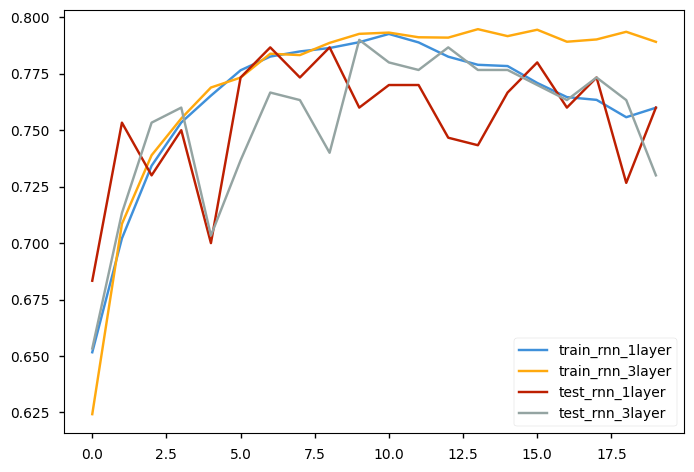

In [24]:
pd.DataFrame(
    {
        "train_rnn_1layer": first_rnn_result.history["sparse_categorical_accuracy"],
        "train_rnn_3layer": rnn_3layer_result.history["sparse_categorical_accuracy"],
        "test_rnn_1layer": first_rnn_callback_predict_test.list_metrics,
        "test_rnn_3layer": rnn_3layer_callback_predict_test.list_metrics,
    }
).plot()

In [25]:
rnn_bidirectional_3layer = models.Sequential(
    [
        layers.Embedding(vocab_size, D),
        layers.Bidirectional(layers.SimpleRNN(hidden_nodes, return_sequences=True)),
        layers.Bidirectional(layers.SimpleRNN(hidden_nodes, return_sequences=True)),
        layers.Bidirectional(layers.SimpleRNN(hidden_nodes)),
        layers.Dense(classes, activation="softmax"),  # (B, D) -> (B, classes)
    ]
)

rnn_bidirectional_3layer.compile(
    optimizer="SGD",
    loss=losses.SparseCategoricalCrossentropy(),
    metrics=[metrics.SparseCategoricalAccuracy()],
)

In [26]:
rnn_bidirectional_3layer_callback_predict_test = CustomEvalDataset(datasets=test_loader)
rnn_bidirectional_3layer_result = rnn_bidirectional_3layer.fit(
    train_loader,
    callbacks=[rnn_bidirectional_3layer_callback_predict_test],
    epochs=20,
    batch_size=16,
    verbose=2,
)

Epoch 1/20
19774/19774 - 86s - 4ms/step - loss: 1.4457 - sparse_categorical_accuracy: 0.6231
Epoch 2/20
19774/19774 - 77s - 4ms/step - loss: 1.2885 - sparse_categorical_accuracy: 0.6897
Epoch 3/20
19774/19774 - 77s - 4ms/step - loss: 1.2327 - sparse_categorical_accuracy: 0.7156
Epoch 4/20
19774/19774 - 81s - 4ms/step - loss: 1.1870 - sparse_categorical_accuracy: 0.7335
Epoch 5/20
19774/19774 - 81s - 4ms/step - loss: 1.1368 - sparse_categorical_accuracy: 0.7489
Epoch 6/20
19774/19774 - 80s - 4ms/step - loss: 1.1097 - sparse_categorical_accuracy: 0.7560
Epoch 7/20
19774/19774 - 81s - 4ms/step - loss: 1.0713 - sparse_categorical_accuracy: 0.7672
Epoch 8/20
19774/19774 - 77s - 4ms/step - loss: 1.0677 - sparse_categorical_accuracy: 0.7713
Epoch 9/20
19774/19774 - 78s - 4ms/step - loss: 1.0356 - sparse_categorical_accuracy: 0.7777
Epoch 10/20
19774/19774 - 78s - 4ms/step - loss: 1.0180 - sparse_categorical_accuracy: 0.7799
Epoch 11/20
19774/19774 - 81s - 4ms/step - loss: 1.0109 - sparse_cate

<Axes: >

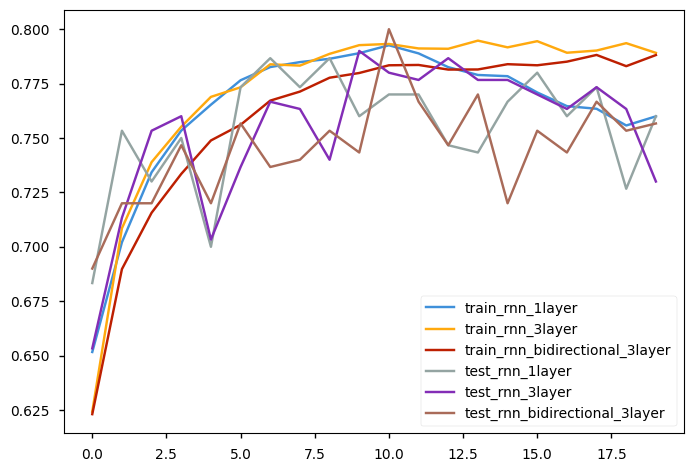

In [28]:
pd.DataFrame(
    {
        "train_rnn_1layer": first_rnn_result.history["sparse_categorical_accuracy"],
        "train_rnn_3layer": rnn_3layer_result.history["sparse_categorical_accuracy"],
        "train_rnn_bidirectional_3layer": rnn_bidirectional_3layer_result.history[
            "sparse_categorical_accuracy"
        ],
        "test_rnn_1layer": first_rnn_callback_predict_test.list_metrics,
        "test_rnn_3layer": rnn_3layer_callback_predict_test.list_metrics,
        "test_rnn_bidirectional_3layer": rnn_bidirectional_3layer_callback_predict_test.list_metrics,
    }
).plot()